# Description

Nowadays, smartphones have enabled people to announce disasters in real time. However, people sometimes use words metaphorically. The project is aimed at predicting whether a tweet is anouncing a real disaster or not.

This is a **Supervised Learning** problem about **NLP**. The training dataset contains 7613 tweets which were hand classified. The training dataset consists of five columns:
- id: a unique identifier of each tweet
- text: the text of the tweet
- location: the location the tweet was sent from
- keyword: a particular keyword from the tweet
- target: denoting whether the tweet is anouncing a real disaster

There is also a test dataset for submission. This test dataset contains 3263 tweets. The "target" column is not included in the test dataset.

Development environment: Ubuntu 24.04 LTS, Python 3.12, PyTorch 2.4.

The GitHub Repo can be found here: https://github.com/spaceship-glitch/tweetdisaster.

# Data Loading, Preprocessing and Exploratory Data Analysis

In [1]:
# import modules
import re
import string
import collections
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryF1Score
from sklearn.model_selection import train_test_split

In [2]:
# download nltk resources if needed
# nltk.download("wordnet")
# nltk.download("stopwords")
# nltk.download('punkt_tab')

In [3]:
# load training dataset
df = pd.read_csv("data/train.csv")

# Info
print("INFO (training)")
print(df.info())
print("")

# describe
print("DESCRIBE (training)")
print(df.describe(include="all"))
print("")

# first 5 rows
print("HEAD (training)")
print(df.head())
print("")

# load test data
df_submission = pd.read_csv("data/test.csv")
print("INFO (test)")
print(df_submission.info())
print("")
print("DESCRIBE (test)")
print(df_submission.describe(include="all"))
print("")
print("HEAD (test)")
print(df_submission.head())

INFO (training)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

DESCRIBE (training)
                  id     keyword location  \
count    7613.000000        7552     5080   
unique           NaN         221     3341   
top              NaN  fatalities      USA   
freq             NaN          45      104   
mean     5441.934848         NaN      NaN   
std      3137.116090         NaN      NaN   
min         1.000000         NaN      NaN   
25%      2734.000000         NaN      NaN   
50%      5408.000000         NaN      NaN   
75%      8146.000000         NaN      NaN   
max     10873.000000         NaN      N

---
The "id", "keyword" and "location" is of no use here. So I drop these two columns

In [4]:
# drop useless columns
df = df.drop(columns=['id', 'keyword', 'location'])

# here 'id' should not be dropped because it will be used in submission file 
df_submission = df_submission.drop(columns=['keyword', 'location'])

---
Then I check whether there are invalid values in the remaining training data.

In [5]:
# check invalid values
na_count = np.sum(df.isnull(), axis=0)
print("Count of null values in the training dataset: ")
print(na_count)

Count of null values in the training dataset: 
text      0
target    0
dtype: int64


---
There are no invalid values in the training dataset. Next, I check whether there are duplicate rows.

In [6]:
# check duplicates
duplicated = df.duplicated(keep='first')
print("Count of duplicated rows: {}".format(np.sum(duplicated)))

Count of duplicated rows: 92


---
The duplicated rows need to be removed.

In [7]:
# remove duplicates
df = df.drop_duplicates(keep='first')
print("Count of rows after dropping duplicates: {}".format(len(df)))

Count of rows after dropping duplicates: 7521


---
Now I check the distribution of the target (0 or 1).

Target counts:
target
0    4315
1    3206
Name: count, dtype: int64


<Axes: xlabel='target', ylabel='Count'>

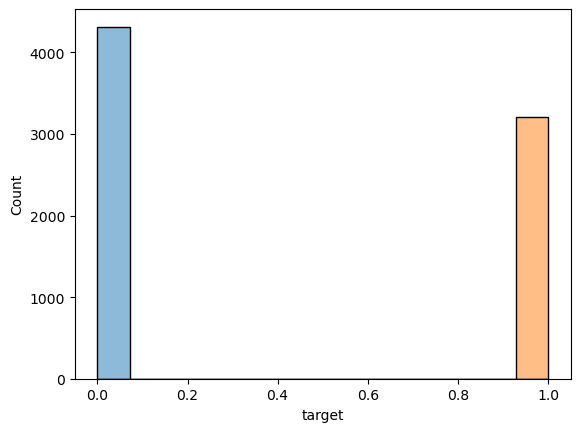

In [8]:
# check distribuiton of "target" column
target_counts = df['target'].value_counts()
print("Target counts:")
print(target_counts)

plt.figure()
sns.histplot(df, x="target", hue="target", legend=False)

---
The count of target value 0 is a little larger than that of 1. But they do not differ too much. I think it is OK to use this data for the following analysis steps.

Then, I perform natural language-specific preprocessing. Numbers, punctuations and stop words (such as "a", "an", "the", "is", etc.) are removed from texts. And since words in english may be shown in different forms in sentences, I use `NLTK` library to perform lemmatization and extract the word stem from each word. 

In [9]:
def preprocess_texts(df):
    # convert all letters to lowercase
    print("Before converting to lowercase:")
    print(df['text'][0])
    
    df['text'] = df['text'].apply(lambda x: x.lower())
    
    print("")
    print("After converting to lowercase:")
    print(df['text'][0])
    
    # remove punctuations
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))
    
    print("")
    print("After removing punctuations:")
    print(df['text'][0])
    
    # removing numbers
    def remove_numbers(text):
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if re.search(r'\d', token) is None]
        return ' '.join(tokens)
    
    df['text'] = df['text'].apply(remove_numbers)
    
    print("")
    print("After removing numbers:")
    print(df['text'][0])
    
    # remove stop words
    sw = stopwords.words('english')
    
    def remove_stop_words(text):
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in sw]
        return ' '.join(tokens)
    
    df['text'] = df['text'].apply(remove_stop_words)
    
    print("")
    print("After removing stop words:")
    print(df['text'][0])
    
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    
    def lemmatize(text):
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(tokens)
    
    df['text'] = df['text'].apply(lemmatize)
    
    print("")
    print("After lemmatization:")
    print(df['text'][0])
    
    # extract word stems
    stemmer = LancasterStemmer()
    
    def extract_stem(text):
        tokens = word_tokenize(text)
        tokens = [stemmer.stem(token) for token in tokens]
        return ' '.join(tokens)
    
    df['text'] = df['text'].apply(extract_stem)
    
    print("")
    print("After extracting word stems:")
    print(df['text'][0])

preprocess_texts(df)
preprocess_texts(df_submission)

Before converting to lowercase:
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

After converting to lowercase:
our deeds are the reason of this #earthquake may allah forgive us all

After removing punctuations:
our deeds are the reason of this earthquake may allah forgive us all

After removing numbers:
our deeds are the reason of this earthquake may allah forgive us all

After removing stop words:
deeds reason earthquake may allah forgive us

After lemmatization:
deed reason earthquake may allah forgive u

After extracting word stems:
dee reason earthquak may allah forg u
Before converting to lowercase:
Just happened a terrible car crash

After converting to lowercase:
just happened a terrible car crash

After removing punctuations:
just happened a terrible car crash

After removing numbers:
just happened a terrible car crash

After removing stop words:
happened terrible car crash

After lemmatization:
happened terrible car crash

After extracting word stems:
ha

---
Next I check the frequencies of the word stems.

Text(0, 0.5, 'Count')

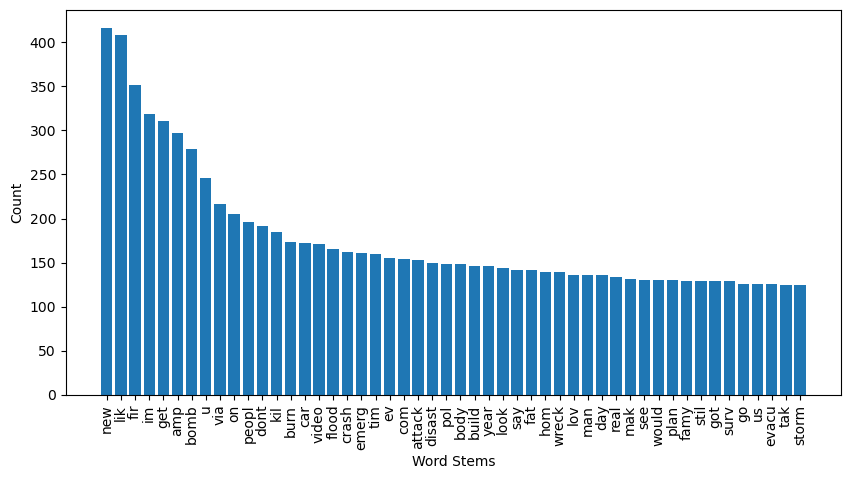

In [10]:
# collect word stems
word_stems = []
def collect_word_stems(text):
    tokens = word_tokenize(text)
    word_stems.extend(tokens)

df['text'].apply(collect_word_stems)

stem_series = pd.Series(word_stems)
stem_counts = stem_series.value_counts(sort=True, ascending=False)

# draw plot of 50 most frequent word 
stem_counts_x = stem_counts.index[:50]
stem_counts_y = stem_counts[:50]
plt.figure(figsize=(10, 5))
plt.bar(stem_counts_x, stem_counts_y)
plt.xlabel("Word Stems")
plt.xticks(rotation=90)
plt.ylabel("Count")

---
To use texts in neural networks, the texts need to be converted into tensors. In this project, a One-Hot vector of size *1 x num_letters* is used to represent each letter. A One-Hot vector is filled with 0's except for a 1 at the index of the current letter. And a text is treated as a sequence of letters instead of words.

In [11]:
# After preprocessing, the texts should contain lowercase and uppercase letters together with space character
# all_letters consists of these characters
all_letters = string.ascii_lowercase + string.ascii_uppercase + ' '
num_letters = len(all_letters)

# Find letter index from all_letters
def letter2Index(letter):
    return all_letters.find(letter)

# convert a text into torch tensor (array of one-hot vectors)
def text2Tensor(text):
    t = torch.zeros(len(text), 1, num_letters)
    for i, letter in enumerate(text):
        t[i, 0, letter2Index(letter)] = 1
    return t

# test
print(text2Tensor("a"))
print(text2Tensor(" "))

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1.]]])


---
Different tweets may contain texts of different lengths. To put them into batches, the tensors are padded so that they have the same size.

In [12]:
# compute max text length
max_text_len = 0

texts_df = df['text']
for i in range(len(texts_df)):
    max_text_len = np.maximum(max_text_len, len(texts_df.iloc[i]))

texts_df_submission = df_submission['text']
for i in range(len(texts_df_submission)):
    max_text_len = np.maximum(max_text_len, len(texts_df_submission.iloc[i]))

print("Max text length: {}".format(max_text_len))

Max text length: 120


---
Then I pad the preprocessed texts to the max length, and convert the texts into tensors.

In [13]:
# convert texts into tensors, pad to the same length
def tensor_from_text_series(series):
    series_text_tensor = torch.zeros(max_text_len, len(series), num_letters)

    for idx_tweet in range(len(series)):
        tweet_text = series.iloc[idx_tweet]
        text_len = len(tweet_text)
        for idx_char in range(text_len):
            # put zero padding before the vector
            series_text_tensor[max_text_len - text_len + idx_char, idx_tweet, letter2Index(tweet_text[idx_char])] = 1

    return series_text_tensor

# postpone this step after dataset splitting
# df_text_tensor = tensor_from_text_series(texts_df)

# Model Architecture

## Vanilla RNN

First, I use a vanilla RNN model because RNN models are suitable for NLP problems. Fortunately, PyTorch provides RNN implementation. However, in the PyTorch RNN implementation, the output feature size must be equal to the hidden size. So I write my own RNN class which wraps the PyTorch RNN class and makes the output feature size to be 1.

In [14]:
# RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        # final output layer
        self.output_layer = nn.Linear(hidden_size, 1)

    # input shape: (L x N x input_size)
    # output shape: (1 x N x 1)
    def forward(self, input):
        output, _ = self.rnn(input)
        output = self.output_layer(output)
        # sigmoid activation
        output = F.sigmoid(output[-1:])
        return output
        

## GRU

As another option, GRU can also be used here. The following class wraps the PyTorch GRU implementation and makes the output feature size to be 1.

In [15]:
# GRU model
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(GRU, self).__init__()

        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        # final output layer
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input):
        output, _ = self.gru(input)
        output = self.output_layer(output)
        # sigmoid function
        output = F.sigmoid(output[-1:])
        return output
    

# Training and Results

In [16]:
# split the training dataset into training data and validation data
df_train, df_val = train_test_split(df, test_size=0.1, random_state=117)
print("training data size: {}".format(len(df_train)))
print("validaiton data size: {}".format(len(df_val)))

text_tensor_train = tensor_from_text_series(df_train['text'])
target_tensor_train = torch.from_numpy(np.array(df_train['target'])).reshape(1, -1, 1)
print("text_tensor_train shape: {}".format(text_tensor_train.shape))
print("target_tensor_train shape: {}".format(target_tensor_train.shape))

text_tensor_val = tensor_from_text_series(df_val['text'])
target_tensor_val = torch.from_numpy(np.array(df_val['target'])).reshape(1, -1, 1)
print("text_tensor_val shape: {}".format(text_tensor_val.shape))
print("target_tesnor_val shape: {}".format(target_tensor_val.shape))

training data size: 6768
validaiton data size: 753
text_tensor_train shape: torch.Size([120, 6768, 53])
target_tensor_train shape: torch.Size([1, 6768, 1])
text_tensor_val shape: torch.Size([120, 753, 53])
target_tesnor_val shape: torch.Size([1, 753, 1])


In [17]:
# training function
def train(model, lr, num_epochs, batch_size, ckpt_fn):
    model = model.cuda()
    batch_num = int(np.ceil(text_tensor_train.shape[1] / batch_size))

    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # BCE loss
    loss_fn = nn.BCELoss()

    losses_train = []
    losses_val = []

    writer = SummaryWriter()

    for epoch in range(num_epochs):
        with torch.no_grad():
            model.eval()

            text_tensor_val_cuda = text_tensor_val.float().cuda()
            target_tensor_val_cuda = target_tensor_val.float().cuda()

            pred_target_cuda = model(text_tensor_val_cuda)
            loss_val = loss_fn(pred_target_cuda, target_tensor_val_cuda)

            losses_val.append(loss_val.item())

            del text_tensor_val_cuda
            del target_tensor_val_cuda
            del pred_target_cuda

        # shuffle training data in each epoch
        indices_shuffled = torch.randperm(text_tensor_train.shape[1])
        loss_epoch = 0
        model.train()
        for i in range(batch_num):
            batch_start = i * batch_size
            batch_end = np.minimum(batch_start + batch_size, len(indices_shuffled))
            batch_tensor_text = text_tensor_train[:, indices_shuffled[batch_start:batch_end], :].float().cuda()
            batch_tensor_target = target_tensor_train[:, indices_shuffled[batch_start:batch_end], :].float().cuda()

            optimizer.zero_grad()
            
            pred_target = model(batch_tensor_text)
            
            loss = loss_fn(pred_target, batch_tensor_target)
            loss_epoch += loss.item()
            loss.backward()
            optimizer.step()

            del batch_tensor_text
            del batch_tensor_target
            del pred_target

        losses_train.append(loss_epoch / batch_num)

        writer.add_scalar("Loss/train", losses_train[-1], epoch)
        writer.add_scalar("Loss/val", losses_val[-1], epoch)

    writer.close()

    model = model.cpu()
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses_train': losses_train,
        'losses_val': losses_val,
        'lr': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size
    }, ckpt_fn)

    del model
    del optimizer
            

In [18]:
def plot_loss(ckpt_fn):
    ckpt_dict = torch.load(ckpt_fn, weights_only=False)
    num_epochs = ckpt_dict['epoch']
    losses_train = ckpt_dict['losses_train']
    losses_val = ckpt_dict['losses_val']

    print("Last training loss: {}".format(losses_train[-1]))
    print("Last validation loss: {}".format(losses_val[-1]))
    
    plt.figure()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    labels_epoch = np.arange(num_epochs)
    plt.plot(labels_epoch, losses_train, label='train')
    plt.plot(labels_epoch, losses_val, label='validation')
    plt.legend()
    plt.show()

---
First, I use the RNN model with hidden_size = 128 and train the model with learning rate = 1e-4 for 2000 epochs.

Last training loss: 0.5883504152297974
Last validation loss: 0.6350643634796143


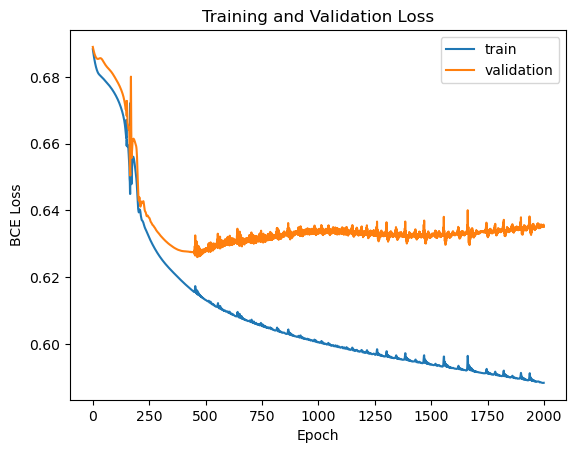

In [19]:
rnn1 = RNN(num_letters, 128)
train(rnn1, 1e-4, 2000, 10000, 'rnn1.ckpt')
plot_loss('rnn1.ckpt')

---
The figure above shows overfitting. Next, I use the same RNN model and reduce the learning rate to 3e-5.

Last training loss: 0.6119189858436584
Last validation loss: 0.629355788230896


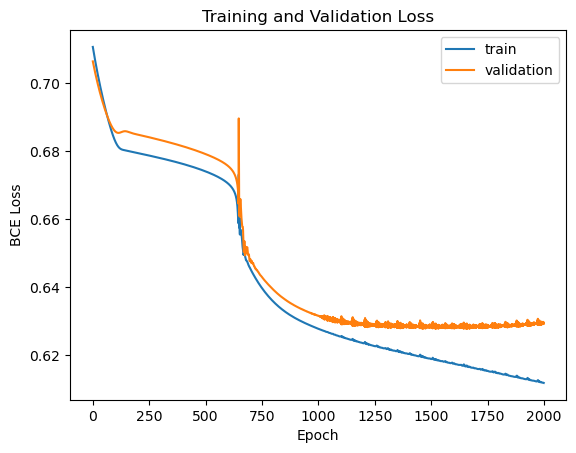

In [20]:
rnn2 = RNN(num_letters, 128)
train(rnn2, 3e-5, 2000, 10000, 'rnn2.ckpt')
plot_loss('rnn2.ckpt')

---
The result of the second training is better than that of the first. Tha validation loss is finally less than 0.63. Next, I try stacked RNN (num_layers = 2).

Last training loss: 0.5753869414329529
Last validation loss: 0.6195182204246521


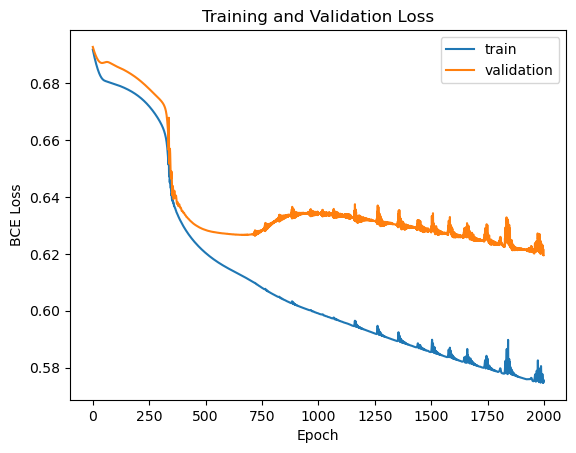

In [21]:
rnn3 = RNN(num_letters, 128, 2)
train(rnn3, 3e-5, 2000, 10000, 'rnn3.ckpt')
plot_loss('rnn3.ckpt')

---
The result of stacked RNN is bad since it shows severe overfitting. I think the reason is that the model is too complex. Finally, I try the GRU model.

Last training loss: 0.6240397989749908
Last validation loss: 0.6279821395874023


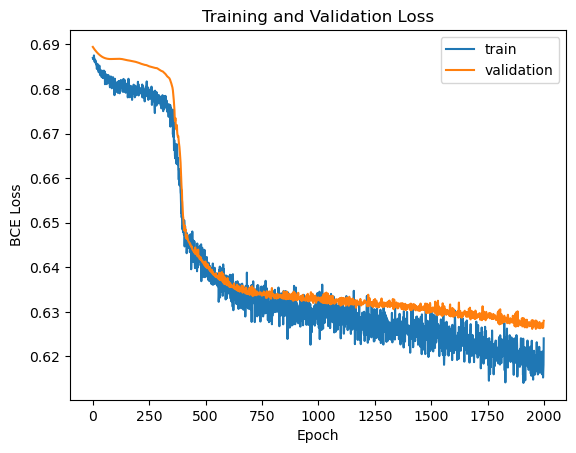

In [22]:
# GRU cell
gru1 = GRU(num_letters, 128)
train(gru1, 3e-5, 2000, 5000, 'gru1.ckpt')
plot_loss('gru1.ckpt')

---
The result of GRU shows little overfitting. And the final validation loss is a little better than that of the second RNN training.

According to the results, the GRU training result is the best (result saved in *gru1.ckpt*). I use this result to generate submission data.

In [24]:
# convert texts to tensors
df_submission_tensor = tensor_from_text_series(df_submission['text']).float().cuda()

# load checkpoint
ckpt_dict = torch.load('gru1.ckpt', weights_only=False)
model = GRU(num_letters, 128)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.cuda()
# predict
pred_targets = model(df_submission_tensor)
mask = pred_targets > 0.5
pred_targets[mask] = 1
pred_targets[~mask] = 0
pred_targets = pred_targets.detach().cpu().numpy().astype(np.int32).reshape(-1)
# dataframe
submission_df = pd.DataFrame(data = {
    'id': df_submission['id'],
    'target': pred_targets
})
# write to file
submission_df.to_csv('data/submission.csv', index=False)

# Conclusion and Discussion

In this project, I treated texts as sequences of characters, converted preprocessed tweet texts into one-hot tensors, and used RNN and GRU to predict whether a tweet indicated a real disaster. A GRU model performs the best, and I used this model to generate submission data. I got a score of 0.63561 on the Kaggle LeaderBoard. This is not a good result. To improve the performance, I think the following means may work:
- Treating texts as sequences of words instead of characters.
- Using other methods to convert texts into tensors.

# References
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html